Wavelet denoising with PyWavelets
=====
by Christopher Schölzel

Author's Note:
------

This notebook is a documentation of my own learning process regarding wavelet denoising.
I have covered the basics of the wavelet transform in [another notebook](https://github.com/CSchoel/learn-wavelets/blob/master/wavelet-introduction.ipynb).
Here, I will therefore assume that the reader is familiar with the basics and dive right into denoising.

For a fast implementation of the DWT we will use [PyWavelets](http://www.pybytes.com/pywavelets/). To install, `conda install pywavelets` 

The problem
------

So, first of all, what is the problem that we want to solve?
Well, we have a signal that is distorted by some kind of noise (we assume white noise here).

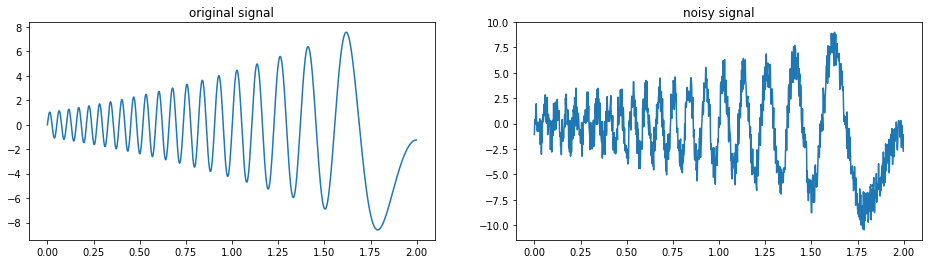

In [2]:
%matplotlib inline
# we will use numpy and matplotlib for all the following examples
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pywt

def doppler(freqs, dt, amp_inc=10, t0=0, f0=np.pi*2):
    t = np.arange(len(freqs)) * dt + t0
    amp = np.linspace(1, np.sqrt(amp_inc), len(freqs))**2
    sig = amp * np.sin(freqs * f0 * t)
    return t,sig

def noisify(sig, noise_amp=1):
    return sig + (np.random.random(len(sig))-0.5)*2*noise_amp
    

t_dop, sig_dop = doppler(np.arange(10,20,0.01)[::-1], 0.002)
sig_dop_n2 = noisify(sig_dop, noise_amp=2)
plt.figure(figsize=(16,4))
plt.subplot(121)
plt.plot(t_dop, sig_dop)
plt.title("original signal")
plt.subplot(122)
plt.plot(t_dop, sig_dop_n2)
plt.title("noisy signal")
plt.show()

Our objective is to transform the signal on the right side back into the signal on the left side.
If we know the frequency range of the original signal, we could try to do this with an ideal low- or high-pass filter using the fourier transform.

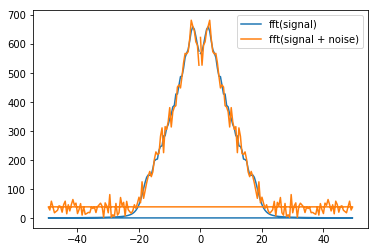

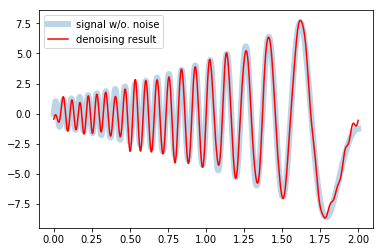

In [3]:
def fourier_denoising(sig, min_freq, max_freq, dt=1.0):
    trans = np.fft.fft(sig)
    freqs = np.fft.fftfreq(len(sig), d=dt)
    trans[np.where(np.logical_or(np.abs(freqs) < min_freq, np.abs(freqs) > max_freq))] = 0
    res = np.fft.ifft(trans)
    return res.real

fsig_dop = np.abs(np.fft.fft(sig_dop))
fsig_dop_n2 = np.abs(np.fft.fft(sig_dop_n2))
freqs_dop = np.fft.fftfreq(len(sig_dop),d=0.002)
idx = np.where(np.abs(freqs_dop) < 50)
plt.plot(freqs_dop[idx], fsig_dop[idx], label="fft(signal)")
plt.plot(freqs_dop[idx], fsig_dop_n2[idx], label="fft(signal + noise)")
plt.legend(loc="best")
plt.show()

fsig_dop_fden = fourier_denoising(sig_dop_n2, 0, 20, dt=0.002)
plt.plot(t_dop, sig_dop, lw=6, alpha=0.3, label="signal w/o. noise")
plt.plot(t_dop, fsig_dop_fden, "r-", label="denoising result")
plt.legend(loc="best")
plt.show()

This approach works reasonably well assuming that the frequency range of the original sequence is known.
This may be the case e.g. for sound data, but still the fourier filters do not address the part of the noise that falls within this frequency range.

Introduction to PyWavelets
------

As we learned before, the discrete wavelet transform is similar to a (windowed) fourier transform and thus there exist approaches for wavelet denoising that are similar to this cropping of frequency ranges.
Before we can have a look into wavelet denoising, we first have to make ourselves familiar with the DWT implementation provided by PyWavelets.

In [4]:
# print the wavelet families available
print(pywt.families())
# print a list of available wavelets from one family
print(pywt.wavelist("sym"))

['haar', 'db', 'sym', 'coif', 'bior', 'rbio', 'dmey', 'gaus', 'mexh', 'morl', 'cgau', 'shan', 'fbsp', 'cmor']
['sym2', 'sym3', 'sym4', 'sym5', 'sym6', 'sym7', 'sym8', 'sym9', 'sym10', 'sym11', 'sym12', 'sym13', 'sym14', 'sym15', 'sym16', 'sym17', 'sym18', 'sym19', 'sym20']


With this functions we get a list of supported wavelet families and individual wavelets.
Now, let's have a look at a single wavelet that we are already familiar with: The Haar wavelet.

In [5]:
# the haar wavelet
haar = pywt.Wavelet("haar")
h, g, hr, gr = haar.filter_bank
print("Haar wavelet highpass filter:",h)
print("Haar wavelet lowpass filter: ",g)
print(haar) # prints a summary of the wavelet properties

Haar wavelet highpass filter: [0.7071067811865476, 0.7071067811865476]
Haar wavelet lowpass filter:  [-0.7071067811865476, 0.7071067811865476]
Wavelet haar
  Family name:    Haar
  Short name:     haar
  Filters length: 2
  Orthogonal:     True
  Biorthogonal:   True
  Symmetry:       asymmetric
  DWT:            True
  CWT:            False


The variable `filter_bank` contains the filters for decomposition and reconstruction.
We printed only the decomposition filters `h` and `g`, because for wavelets that constitute an orthogonal basis the reconstruction filters `hr` and `gr` are only reversed versions of `h` and `g`.

For the Haar wavelet, it is not really interesting to plot the wavelet functions $\phi$ and $\psi$.
Therefore we will now look at another wavelet from the "least asymmetric" wavelet family introduced by Daubechies (also called "Symlets".

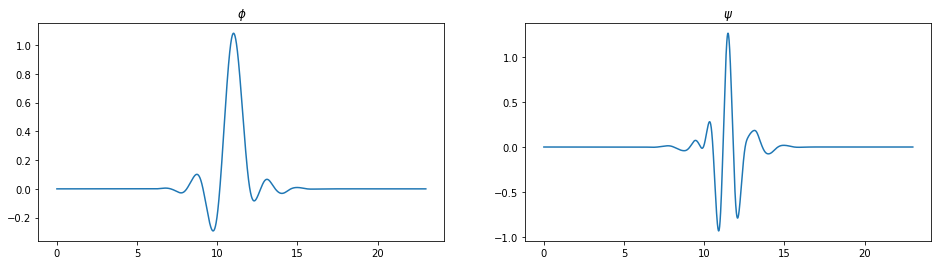

In [6]:
# Daubechies "least asymmetric" wavelets with 12 vanishing points
sym12 = pywt.Wavelet("sym12")
phi_s12, psi_s12, x_s12 = sym12.wavefun(8)
plt.figure(figsize=(16,4))
plt.subplot(121)
plt.title("$\phi$")
plt.plot(x_s12,phi_s12)
plt.subplot(122)
plt.title("$\psi$")
plt.plot(x_s12,psi_s12)
plt.show()

As an interesting side-note, the Symlet wavelets actually do not have a closed form solution.
The scaling function $\phi$ (also called the "father wavelet") and the wavelet function $\psi$ (also called the "father wavelet") both have to be estimated for any given detail level.

Now that we have seen a wavelet function it is time to learn how to perform a discrete wavelet transform with PyWavelets.

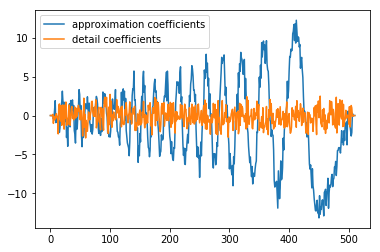

In [7]:
cA, cD = pywt.dwt(sig_dop_n2, "sym12", mode="zero")
plt.plot(cA, label="approximation coefficients")
plt.plot(cD, label="detail coefficients")
plt.legend(loc="best")
plt.show()

We can see the approximation coefficients that actually follow the original signal and the detail coefficiens that look more like the noise that we added to the signal.
Actually, the detail coefficients at this level of the DWT *are* a result of noise.
The original signal does not contain such high frequencies.

We can confirm this expectation by looking at the whole range of coefficients for a full decomposition with the DWT.

/Users/bem/miniconda3/envs/unidata/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


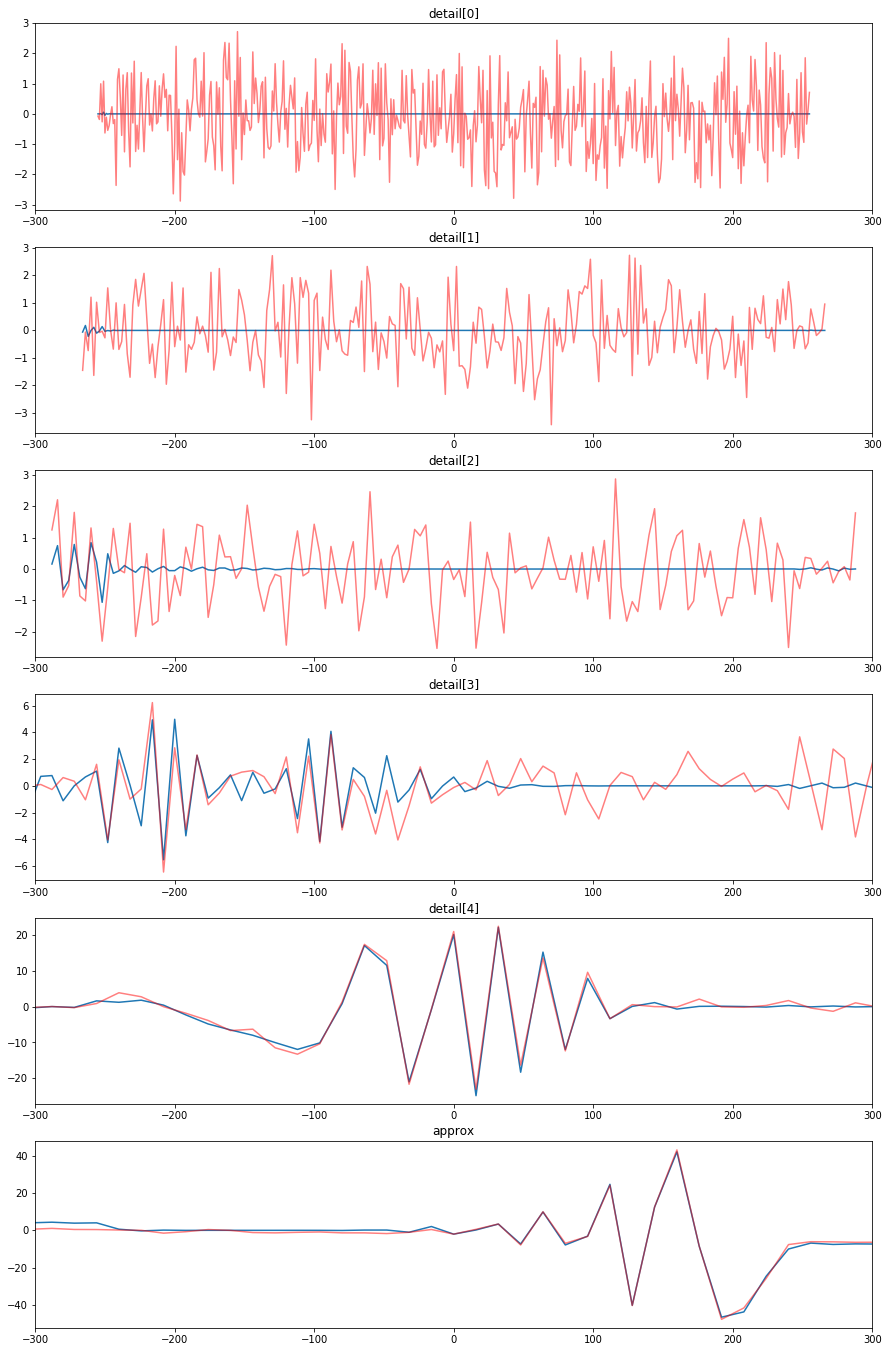

In [8]:
coeffs = pywt.wavedec(sig_dop, "sym12")
approx = coeffs[0]
details = coeffs[1:]
coeffs_n = pywt.wavedec(sig_dop_n2, "sym12")
approx_n = coeffs_n[0]
details_n = coeffs_n[1:]

def plot_dwt(details, approx, xlim=(-300,300), **line_kwargs):
    for i in range(len(details)):
        plt.subplot(len(details)+1,1,i+1)
        d = details[len(details)-1-i]
        half = len(d)//2
        xvals = np.arange(-half,-half+len(d))* 2**i
        plt.plot(xvals, d, **line_kwargs)
        plt.xlim(xlim)
        plt.title("detail[{}]".format(i))
    plt.subplot(len(details)+1,1,len(details)+1)
    plt.title("approx")
    plt.plot(xvals, approx, **line_kwargs)
    plt.xlim(xlim)

plt.figure(figsize=(15,24))
plot_dwt(details, approx)
plot_dwt(details_n, approx_n, color="red", alpha=0.5)
plt.show()

Indeed, we can see that `detail[0]`, `detail[1]` and `detail[2]` are mostly zero for the original signal but have higher values for the noisy signal.

Another interesting observation is that the coefficients wander from left to right with increasing coarseness of the approximation, which corresponds to the frequency range of the signal: On the left side we have a high frequency, which decreases to the left.

We can of course use this property for our denoising by setting the detail coefficients of the first levels of the decomposition to zero, but this would only result in a less precise fourier denoising.
Instead we can follow another lead pointed out by Tony Cai and Bernard Silverman[[1]](#ref1), who developed the "NeighBlock" method.

<a name="ref1">[1]</a> [Cai, T. T. & Silverman, B. W. Incorporating information on neighbouring coefficients into wavelet estimation. Sankhyā: The Indian Journal of Statistics, Series B 127–148 (2001)](http://web.maths.bris.ac.uk/research/stats/reports/1999/9922.pdf)


Wavelet denoising with NeighBlock
-------

In general it is more likely that a detail coefficient is part of a signal if the neighboring coefficients also contain some signal.

TODO: more description

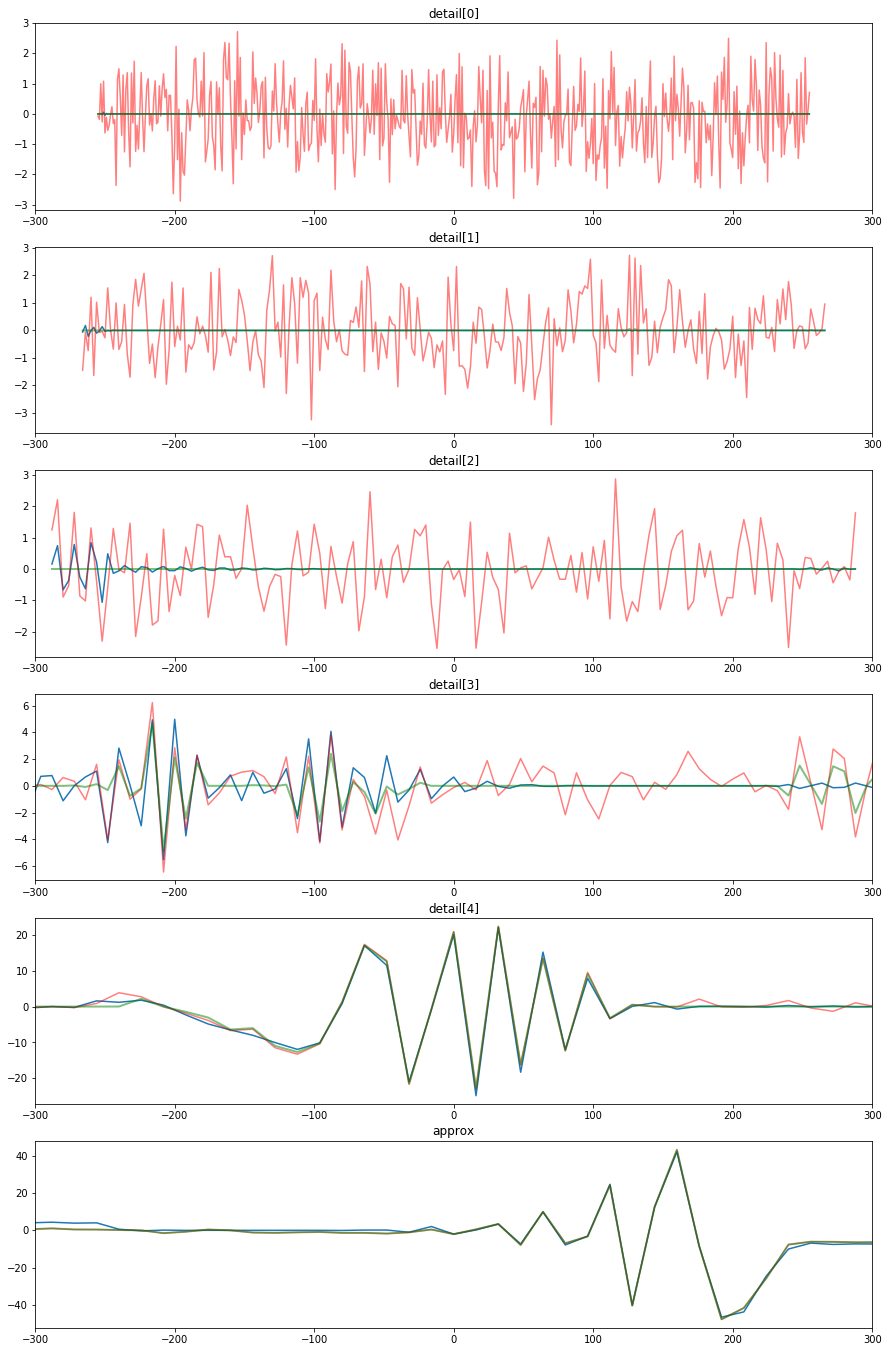

In [9]:
def neigh_block(details, n, sigma):
    res = []
    L0 = int(np.log2(n) // 2)
    L1 = max(1, L0 // 2)
    L = L0 + 2 * L1
    def nb_beta(sigma, L, detail):
        S2 = np.sum(detail ** 2)
        lmbd = 4.50524 # solution of lmbd - log(lmbd) = 3
        beta = (1 - lmbd * L * sigma**2 / S2)
        return max(0, beta)
    for d in details:
        d2 = d.copy()
        for start_b in range(0, len(d2), L0):
            end_b = min(len(d2), start_b + L0)
            start_B = start_b - L1
            end_B = start_B + L
            if start_B < 0:
                end_B -= start_B
                start_B = 0
            elif end_B > len(d2):
                start_B -= end_B - len(d2)
                end_B = len(d2)
            assert end_B - start_B == L
            d2[start_b:end_b] *= nb_beta(sigma, L, d2[start_B:end_B])
        res.append(d2)
    return res

details_nb = neigh_block(details_n, len(sig_dop), 0.8)
plt.figure(figsize=(15,24))
plot_dwt(details, approx)
plot_dwt(details_n, approx_n, color="red", alpha=0.5)
plot_dwt(details_nb, approx_n, color="green", alpha=0.5, lw=2)
plt.show()

TODO: Description

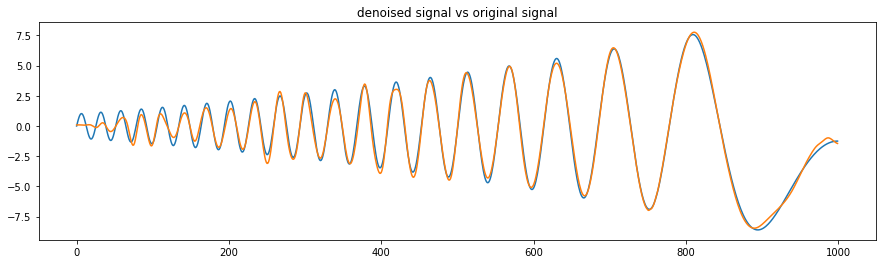

In [10]:
sig_dop_dn = pywt.waverec([approx_n] + details_nb, "sym12")
plt.figure(figsize=(15,4))
plt.title("denoised signal vs original signal")
plt.plot(sig_dop)
plt.plot(sig_dop_dn)
#plt.plot(fsig_dop_fden)
plt.show()